In [1]:
import numpy as np
import timeit
import sys
import pandas as pd
from typing import NamedTuple, List, Tuple

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from main import MeasurementControlEnvironment
from utils import get_ellipse_scaling

In [2]:
class ObjectManager:
    def __init__(self):
        pass

In [11]:
class ObjectTuple(NamedTuple):
    object_type: str
    shape: str
    mean: np.ndarray
    ooi_id: int=None
    points: np.ndarray=None
    covariances: List[np.ndarray]=None
    radius: float=None

obj1 = ObjectTuple(object_type='obstacle',
                   shape='circle',
                   mean=np.array([20, 20]),
                   radius=1.0
)

obj2 = ObjectTuple(object_type='obstacle',
                   shape='4polygon',
                   mean=np.array([10, 10]),
                   points=np.array([[10, 10],[14, 10], [14, 14], [10, 14]])
)

obj3 = ObjectTuple(object_type='occlusion',
                   shape='circle',
                   mean=np.array([40, 40]),
                   radius=1.0
)

obj4 = ObjectTuple(object_type='occlusion',
                   shape='4polygon',
                   mean=np.array([30, 30]),
                   points=np.array([[30, 30],[34, 30], [34, 34], [30, 34]])
)

obj5 = ObjectTuple(object_type='ooi',
                   shape='4polygon',
                   mean=np.array([60, 60]),
                   ooi_id=0,
                   points=np.array([[60, 60],[64, 60], [64, 64], [60, 64]]),
                   covariances=[np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5])]
)


df = pd.DataFrame([obj1, obj2, obj3, obj4, obj5])
df.head()

,object_type,shape,mean,ooi_id,points,covariances,radius
0,obstacle,circle,"[20, 20]",NaN,None,None,1.0
1,obstacle,4polygon,"[10, 10]",NaN,"[[10, 10], [14, 10], [14, 14], [10, 14]]",None,NaN
2,occlusion,circle,"[40, 40]",NaN,None,None,1.0
3,occlusion,4polygon,"[30, 30]",NaN,"[[30, 30], [34, 30], [34, 34], [30, 34]]",None,NaN
4,ooi,4polygon,"[60, 60]",0.0,"[[60, 60], [64, 60], [64, 64], [60, 64]]","[[[3.5, 0.0], [0.0, 2.5]], [[3.5, 0.0], [0.0, ...",NaN


In [12]:
def draw_objects(env, df: pd.DataFrame):
    # Iterate through the rows of the dataframe
    for tuple in df.itertuples(index=True, name='ObjectTuple'):
        if tuple.object_type == 'obstacle':
            if tuple.shape == '4polygon':
                # Draw the polygon
                env.ui.draw_polygon(tuple.points, linestyle='-', color='r', facecolor='r', alpha=0.2)
            elif tuple.shape == 'circle':
                # Draw the circle
                env.ui.draw_circle(tuple.mean, tuple.radius, color='r', facecolor='r', alpha=0.2)
            else:
                raise ValueError('Unknown shape')
        elif tuple.object_type == 'occlusion':
            if tuple.shape == '4polygon':
                # Draw the polygon
                env.ui.draw_polygon(tuple.points, linestyle='-', color='y', facecolor='y', alpha=0.3)
            elif tuple.shape == 'circle':
                # Draw the circle
                env.ui.draw_circle(tuple.mean, tuple.radius, color='y', facecolor='y', alpha=0.3)
            else:
                raise ValueError('Unknown shape')
            
        elif tuple.object_type == 'ooi':
            if tuple.shape != '4polygon':
                raise ValueError('OOIs must be 4polygons')
            # Draw the polygon
            env.ui.draw_polygon(tuple.points, color='b', facecolor='None', linestyle='--', alpha=1.0)
            
            # Draw the points
            for point in tuple.points:
                env.ui.draw_point(point, color='cyan')
                
            # Draw the covariance ellipses
            for pt, cov in zip(tuple.points, tuple.covariances):
                scalings, angle = get_ellipse_scaling(cov)
                env.ui.draw_ellipse(pt, scalings[0], scalings[1], angle=angle, color='b', alpha=0.25, linestyle='-')


Toy Measurement Control Initialized


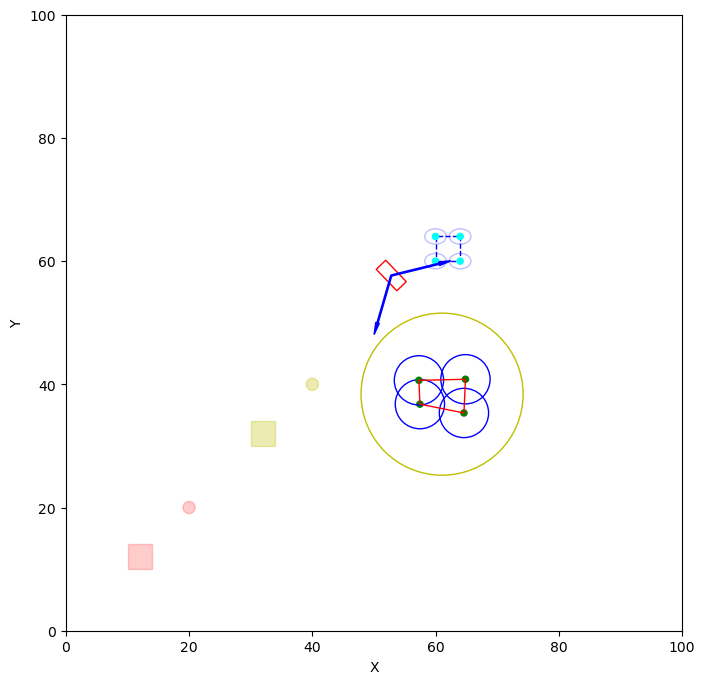

In [13]:
env = MeasurementControlEnvironment()
state = env.reset()
draw_objects(env, df)
env.draw_state(state, explore_grid=False)